In [1]:
import numpy as np
import tensorflow as tf
from art.attacks.evasion import BasicIterativeMethod
from art.estimators.classification import TensorFlowV2Classifier
import matplotlib.pyplot as plt


D:\Tarun\Desktop\mlProj\my_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [3]:
# Preprocess data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


In [4]:
# Use a smaller subset of the dataset
subset_size = 1000  # Adjust this size as needed
x_test_subset = x_test[:subset_size]
y_test_subset = y_test[:subset_size]

In [5]:
# Create a simple CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

D:\Tarun\Desktop\mlProj\my_venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [7]:
# Train the model
model.fit(x_train, y_train, epochs=10, validation_split=0.1, batch_size=64)


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3481 - loss: 1.7597 - val_accuracy: 0.5416 - val_loss: 1.2941
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5603 - loss: 1.2312 - val_accuracy: 0.6198 - val_loss: 1.0913
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6301 - loss: 1.0512 - val_accuracy: 0.6390 - val_loss: 1.0428
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6664 - loss: 0.9507 - val_accuracy: 0.6676 - val_loss: 0.9666
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6962 - loss: 0.8621 - val_accuracy: 0.6720 - val_loss: 0.9270
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7248 - loss: 0.7883 - val_accuracy: 0.7112 - val_loss: 0.8473
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7432 - loss: 0.7325 - val_accuracy: 0.6908 - val_loss: 0.8991
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7611 - loss: 0.6741 - val_accuracy:

In [8]:
# Define the loss function
loss_object = tf.keras.losses.CategoricalCrossentropy()

In [9]:
# Create ART classifier with loss function
classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(32, 32, 3), loss_object=loss_object)


In [10]:
# Initialize BIM attack
attack = BasicIterativeMethod(estimator=classifier, eps=0.1, eps_step=0.01, max_iter=10)


In [11]:
# Iterate over a range of eps values
eps_values = np.linspace(0.01, 0.1, num=10)
accuracies = []

for eps in eps_values:
    # Update the attack with the current eps value
    attack.set_params(eps=eps)

    # Generate adversarial examples
    x_adv = attack.generate(x=x_test_subset)

    # Evaluate model accuracy on adversarial examples
    accuracy = np.mean(np.argmax(classifier.predict(x_adv), axis=1) == np.argmax(y_test_subset, axis=1))
    accuracies.append(accuracy)

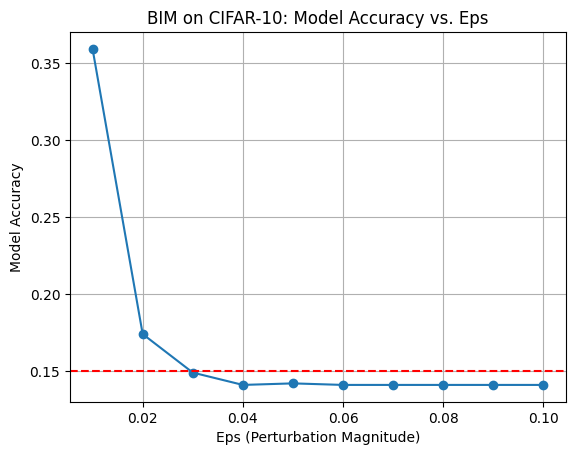

Maximum eps value after which the model fails (accuracy <= 15%): 0.03


In [14]:
# Plot the graph
plt.plot(eps_values, accuracies, marker="o")
plt.axhline(y=0.15, color='r', linestyle='--')
plt.xlabel("Eps (Perturbation Magnitude)")
plt.ylabel("Model Accuracy")
plt.title("BIM on CIFAR-10: Model Accuracy vs. Eps")
plt.grid(True)
plt.show()

print(f"Maximum eps value after which the model fails (accuracy <= 15%): {eps_values[np.where(np.array(accuracies) <= 0.15)[0][0]]:.2f}")